In [1]:
from numcosmo_py import Ncm, Nc
import sys
import math
import matplotlib.pyplot as plt
import numpy as np
import warnings
from matplotlib.pyplot import cm

from scipy.integrate import odeint
from scipy.interpolate import interp1d
from numcosmo_py.plotting.tools import set_rc_params_article, latex_float

In [2]:
__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [3]:
set_rc_params_article(ncol=2)

In [4]:
qgw = Nc.HICosmoQGW.new()
adiab = Nc.HIPertAdiab.new()

In [5]:
qgw.props.xb = 1.0e35
qgw.props.w = 1.0e-5

In [6]:

tAi = -300.0
tAf = -5.0e-2

ki = 1.0e0
kf = 1.0e2
k_a = np.geomspace(ki, kf, 1000)

adiab.set_k(1.0e-1)
adiab.set_ti(-300.0)
adiab.set_tf(-1.0)
adiab.set_reltol(1.0e-11)
adiab.set_max_order_2(False)

Found, tAD = adiab.find_adiab_time_limit(qgw, tAi, tAf, 1.0e-3)

print(f"Found: {Found}, tAD: {tAD}")

Found: True, tAD: -150.22941011392186


In [7]:
adiab.set_init_cond_adiab(qgw, tAD)
adiab.prepare(qgw)

In [8]:
ta, ts = adiab.get_time_array()

In [9]:
Pzeta = [adiab.eval_powspec_zeta_at(qgw, t) for t in ta]
PPsi = [adiab.eval_powspec_Psi_at(qgw, t) for t in ta]
Pdrho = [adiab.eval_powspec_drho_at(qgw, t) for t in ta]

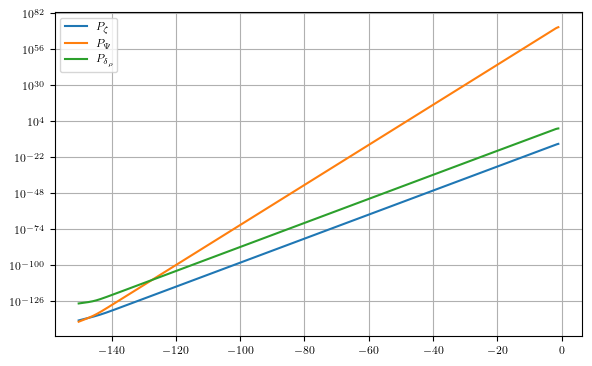

In [10]:
fig = plt.figure()

plt.plot(ta, Pzeta, label="$P_\zeta$")
plt.plot(ta, PPsi, label="$P_\Psi$")
plt.plot(ta, Pdrho, label=r"$P_{\delta_\rho}$")

plt.yscale('log')

plt.grid()
plt.legend()

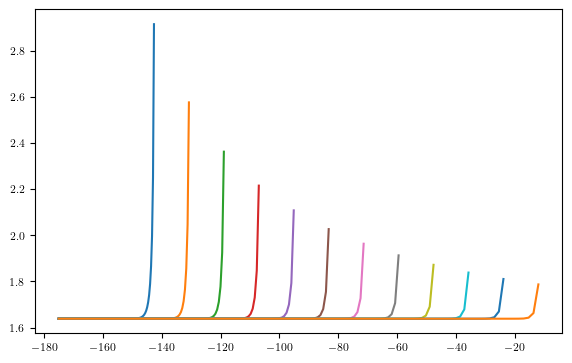

In [11]:
for k in np.geomspace(1.0e-3, 1.0e30, 20):
    adiab.set_k(k)
    tau_max = -qgw.eval_tau_hubble(0.0, k)
    tau_l_a = np.linspace(-175.0, tau_max, 100)

    plt.plot(tau_l_a, [adiab.eval_delta_critial(qgw, tau) for tau in tau_l_a])


In [12]:
ka = np.geomspace(1.0e-2, 1.0e32, 1000)
tau_a = np.linspace(-25.0, -1.0, 40)

In [13]:
adiab.prepare_spectrum(qgw, -1.0e-15, 1.0e-7, ka, tau_a)

In [14]:
Pzetak = adiab.eval_powspec_zeta(qgw)
PPsik = adiab.eval_powspec_Psi(qgw)
Pdrhok = adiab.eval_powspec_drho(qgw)

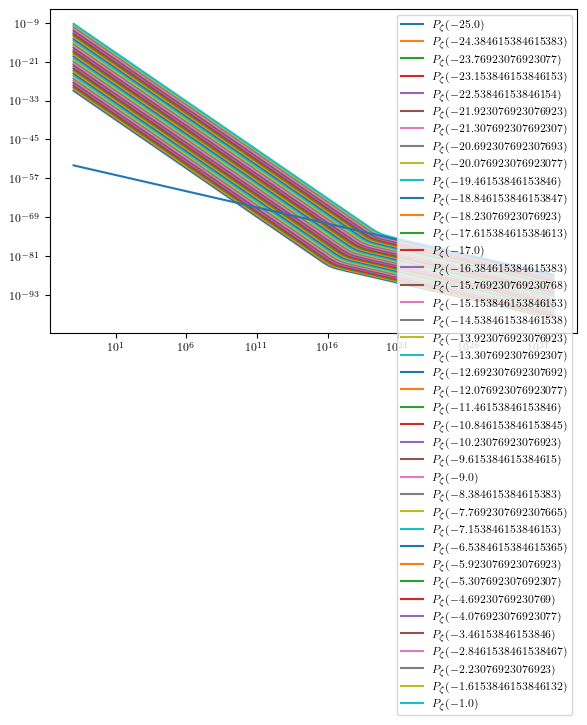

In [15]:
fig = plt.figure()

tau_plot_a = tau_a
for tau in tau_plot_a:
    plt.plot(ka, [Pzetak.eval(None, tau, k) for k in ka], label=f"$P_\zeta({tau})$")

plt.plot(ka, 1.0e-55 * ka**(-1))

plt.xscale('log')
plt.yscale('log')
plt.legend()
pass

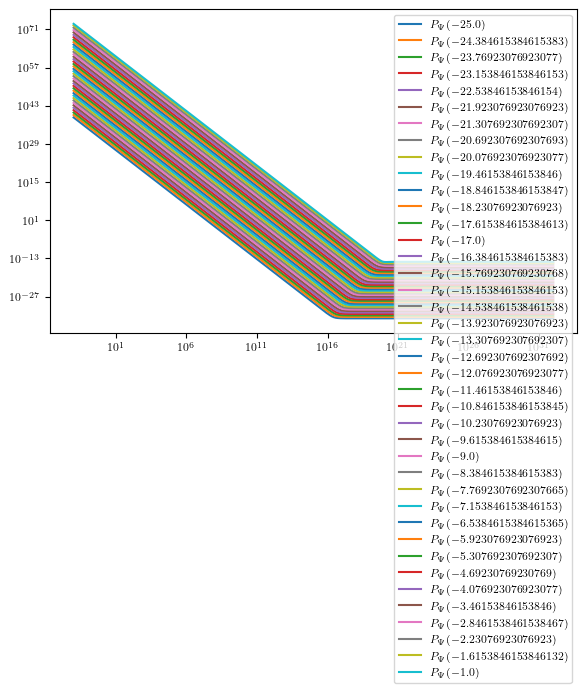

In [16]:
fig = plt.figure()

tau_plot_a = tau_a
for tau in tau_plot_a:
    plt.plot(ka, [k**3 * PPsik.eval(None, tau, k) for k in ka], label=rf"$P_\Psi({tau})$")

plt.xscale('log')
plt.yscale('log')
plt.legend()
pass

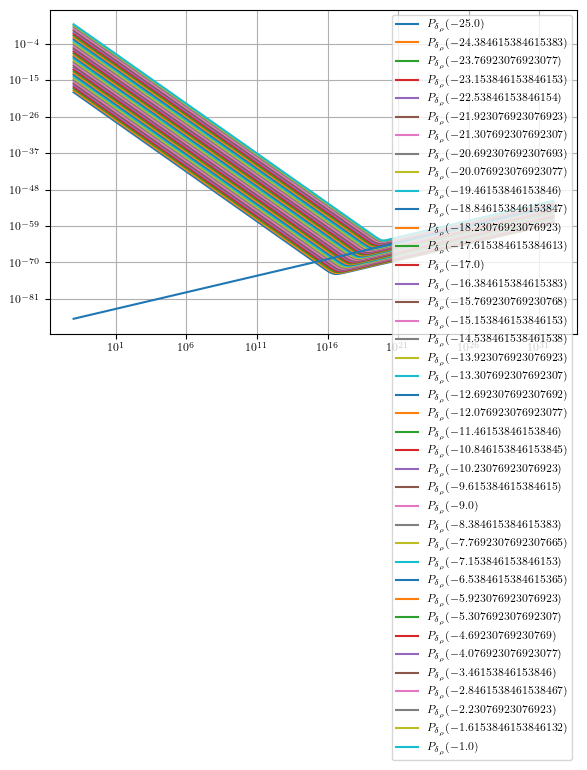

In [17]:
fig = plt.figure()

tau_plot_a = tau_a
for tau in tau_plot_a:
    plt.plot(ka, [Pdrhok.eval(None, tau, k) for k in ka], label=rf"$P_{{\delta_\rho}}({tau})$")

plt.plot(ka, 1.0e-85 * ka**1)

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid()
pass

In [18]:
psf_zeta = Ncm.PowspecFilter.new(Pzetak, Ncm.PowspecFilterType.TOPHAT)
psf_zeta.set_best_lnr0()

psf_Psi = Ncm.PowspecFilter.new(PPsik, Ncm.PowspecFilterType.TOPHAT)
psf_Psi.set_best_lnr0()

psf_drho = Ncm.PowspecFilter.new(Pdrhok, Ncm.PowspecFilterType.TOPHAT)
psf_drho.set_best_lnr0()

psf_zeta.prepare(qgw)
psf_Psi.prepare(qgw)
psf_drho.prepare(qgw)

In [19]:
for tau in tau_a:
    print(f"{qgw.eval_x(tau)} {Pzetak.sigma_tophat_R(qgw, 1.0e-5, tau, 1.0e-25)} {1.0e-30/qgw.eval_x(tau)}")

9.170117964415344e+27 2.4211587692928604e-10 1.0904985125387716e-58
1.3821296997030888e+28 3.6491956327298967e-10 7.235210995139035e-59
2.083160232195703e+28 5.500105542365689e-10 4.8003988581616454e-59
3.1397607286305303e+28 8.289816173689487e-10 3.184956072866642e-59
4.732279966126183e+28 1.249449699905335e-09 2.1131463209235997e-59
7.132541493875901e+28 1.88318355906164e-09 1.4020247913855307e-59
1.075024058720387e+29 2.83835381079267e-09 9.302117398100942e-60
1.6202874218396512e+29 4.277996330456269e-09 6.171744509777249e-60
2.4421140234728794e+29 6.447840481975112e-09 4.094812897302481e-60
3.6807796093803805e+29 9.718252113732627e-09 2.716815745912968e-60
5.547709239867445e+29 1.4647450477425115e-08 1.8025458018125944e-60
8.361564960769733e+29 2.207678942445339e-08 1.1959483717363166e-60
1.2602637515812327e+30 3.327436621429937e-08 7.93484696156115e-61
1.8994826100153727e+30 5.0151470201411214e-08 5.264591498376008e-61
2.86291990960136e+30 7.558881654317302e-08 3.4929373911100516e

print(psf_zeta.eval_sigma(-10.0, 1.0))
print(psf_Psi.eval_sigma(-10.0, 1.0))
print(psf_drho.eval_sigma(-10.0, 1.0e-8))

In [ ]:
r_a = np.geomspace(psf_drho.get_r_min(), psf_drho.get_r_max(), 1000)
psf_zeta.prepare(qgw)

fig = plt.figure()

for tau in tau_a:
    sigma_r = [Pdrhok.sigma_tophat_R(qgw, 1.0e-5, tau, r) for r in r_a]
    plt.plot(r_a, sigma_r)
plt.xscale('log')
plt.yscale('log')

In [ ]:
fig = plt.figure()

for tau in tau_a:
    sigma_r = np.abs([psf_drho.eval_sigma(tau, r) for r in r_a])
    plt.plot(r_a, sigma_r)
plt.xscale('log')
plt.yscale('log')

In [ ]:
r0 = 1.0e-9
for tau in tau_a:
    print(psf_drho.eval_sigma(tau, r0))